# Notebook for Generating and Saving Freshmen&Sophomores Dataset

In [1]:
import numpy as np
import torch
import pickle
import time
import os
import dgl

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.sparse

Using backend: pytorch


## Generate Freshmen&Sophomores Social Network

In [2]:
class Dataset_Generator():
    def __init__(self, params):
        self.nb_freshmen = params['nb_freshmen']
        self.nb_sophomores = params['nb_sophomores']
        self.dsize = self.nb_freshmen + self.nb_sophomores
        self.intra_freshmen = params['intra_freshmen']
        self.intra_sophomores = params['intra_sophomores']
        self.inter_freshmen_sophomores = params['inter_freshmen_sophomores']
        self.vocab_size = params['vocab_size']
        self.labels = []
        self.adj = [[]]
        self.rand_idx = []
        self.node_feat = []
        self.generate()
    
    def _randomize(self):
        # relabel nodes (students) at random
        idx = np.random.permutation(self.dsize)
        self.adj = self.adj[idx,:]
        self.adj = self.adj[:,idx]
        self.labels = self.labels[idx]
        self.node_feat = self.node_feat[idx]
        self.rand_idx = idx
    
    def _gen_labels(self, n0, n1):
        # generate student labels. 
        # Freshman: 0; Sophomore: 1
        c0 = np.repeat(0, n0, axis=0)
        c1 = np.repeat(1, n1, axis=0)
        c = np.concatenate([c0, c1])
        return c
    
    def _gen_node_feat(self, vocab_size):
        x  = np.random.randint(vocab_size, size=self.dsize)
        return x
         
    def _gen_intra_class_conn(self, n, p):
        # generate intra-class adjacency matrix
        A = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                if np.random.binomial(1, p)==1:
                    A[i, j]=1
                    A[j, i]=1
        return A
                
    def _gen_inter_class_conn(self, n0, n1, q):
        # generate inter-class adjacency matrix
        A = np.zeros((n0, n1))
        for i in range(n0):
            for j in range(n1):
                if np.random.binomial(1, q)==1:
                    A[i, j]=1
        return A
    
    def _gen_adj(self, nf, pf, ns, ps, q):
        # generate ordered adjacency matrix
        Af = self._gen_intra_class_conn(nf, pf)
        As = self._gen_intra_class_conn(ns, ps)
        Afs = self._gen_inter_class_conn(nf, ns, q)
        A_up = np.concatenate((Af, Afs), axis=1)
        A_down = np.concatenate((Afs.T, As), axis=1)
        A = np.concatenate((A_up, A_down), axis=0)
        return A
    
    def generate(self):
        # regenerate dataset
        self.labels = self._gen_labels(self.nb_freshmen, self.nb_sophomores)
        self.adj = self._gen_adj(self.nb_freshmen, self.intra_freshmen, 
                            self.nb_sophomores, self.intra_sophomores,
                            self.inter_freshmen_sophomores)
        self.node_feat = self._gen_node_feat(self.vocab_size)
        self._randomize()

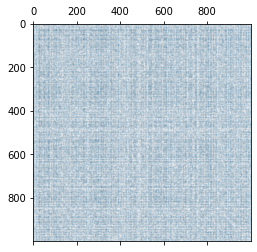

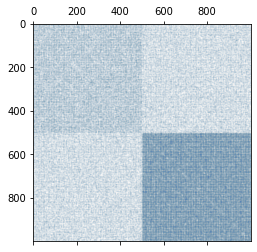

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [3]:
# dataset configuration
dataset_params = {}
dataset_params['nb_freshmen']=500
dataset_params['nb_sophomores']=500
dataset_params['intra_freshmen'] = 0.3
dataset_params['intra_sophomores'] = 0.6
dataset_params['inter_freshmen_sophomores'] = 0.2
dataset_params['vocab_size'] = 3

# generate dataset
data = Dataset_Generator(dataset_params)
attrs = vars(data)

# visualize randomized adjacency matrix 
A = data.adj
plt.spy(A, precision=0.01, markersize=0.01)
plt.show()

# visualized clustered adjacency matrix
idx = np.argsort(data.rand_idx)
A_sorted = A[idx, :]
A_sorted = A_sorted[:, idx]
plt.spy(A_sorted, precision=0.01, markersize=0.01)
plt.show()
labels_sorted = data.labels[idx]
print(labels_sorted)

## Save dataset

In [4]:
class DotDict(dict):
    def __init__(self,**kwds):
        self.update(kwds)
        self.__dict__ = self

start = time.time()
data = Dataset_Generator(dataset_params)
with open('freshman_sophomore_dataset.pkl',"wb") as f:
    pickle.dump(data,f)
print("Time (sec):", time.time() - start)

Time (sec): 1.999197244644165


## Convert to DGL format and save

In [5]:
class DGL_Converter(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, name):
        with open(os.path.join(data_dir, name + '.pkl'), 'rb') as f:
            self.dataset = pickle.load(f)
        self.graph = []
        self.labels = []
        self._prepare()
        
    def _prepare(self):
        print("preparing...")
        
        # test
        node_features = np.expand_dims(data.node_feat, axis=1)

        adj = torch.from_numpy(data.adj).to(torch.int8)
        dsize = adj.shape[0]
        edge_list = (data.adj != 0).nonzero() 
        
        # create DGL Graph
        g = dgl.DGLGraph()
        g.add_nodes(node_features.shape[0])
        g.ndata['feat'] = torch.FloatTensor(node_features)
        for i in range(len(edge_list[0])):
            src = edge_list[0][i]
            dst = edge_list[1][i]
            g.add_edges(src, dst)
        edge_feat_dim = 1
        g.edata['feat'] = torch.ones(g.number_of_edges(), edge_feat_dim).long()
        print("done!")
        print(g)
        
        self.graph.append(g)
        self.labels.append(data.labels)

data_dir = ''
name = 'freshman_sophomore_dataset'
dataset = DGL_Converter(data_dir, name)

preparing...
done!
DGLGraph(num_nodes=1000, num_edges=324932,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.int64)})


# Given graph

In [6]:
import torch.nn as nn
from dgl.nn.pytorch.conv import TAGConv

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        '''
        1st graph convolutional layer
        1 input feature, 16 output feature (hidden units)
        order-2 graph filter
        '''
        self.layer1 = TAGConv(1, 16, 2)
        
        '''
        2nd graph convolutional layer
        16 input feature, 2 output feature (hidden units)
        order-3 graph filter
        '''
        self.layer2 = TAGConv(16, 2, 3)

    def forward(self, g, features):
        x = self.layer1(g, features)
        x = F.relu(x)
        x = self.layer2(g, x)
        return x
    
net = Net()
print(net)

g = dataset.graph[0]
print(g)
labels = torch.LongTensor(dataset.labels[0])
features = g.ndata['feat']
train_mask = torch.LongTensor(np.arange(200))
test_mask = torch.LongTensor(np.arange(200,1000))

def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

import time
import numpy as np
import torch.nn.functional as F

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
all_logits = []
all_acc = []

for epoch in range(150):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    all_logits.append(logits.detach()) # for visualization
    
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = evaluate(net, g, features, labels, test_mask)
    all_acc.append(acc)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
            epoch, loss.item(), acc))

acc_A = all_acc

Net(
  (layer1): TAGConv(
    (lin): Linear(in_features=3, out_features=16, bias=True)
  )
  (layer2): TAGConv(
    (lin): Linear(in_features=64, out_features=2, bias=True)
  )
)
DGLGraph(num_nodes=1000, num_edges=324932,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.int64)})
Epoch 00000 | Loss 0.8365 | Test Acc 0.4475
Epoch 00001 | Loss 0.7867 | Test Acc 0.5112
Epoch 00002 | Loss 0.7936 | Test Acc 0.4975
Epoch 00003 | Loss 0.7661 | Test Acc 0.4988
Epoch 00004 | Loss 0.7374 | Test Acc 0.4950
Epoch 00005 | Loss 0.7262 | Test Acc 0.4950
Epoch 00006 | Loss 0.7237 | Test Acc 0.4950
Epoch 00007 | Loss 0.7151 | Test Acc 0.4950
Epoch 00008 | Loss 0.7004 | Test Acc 0.4950
Epoch 00009 | Loss 0.6883 | Test Acc 0.4950
Epoch 00010 | Loss 0.6834 | Test Acc 0.6300
Epoch 00011 | Loss 0.6820 | Test Acc 0.7900
Epoch 00012 | Loss 0.6780 | Test Acc 0.7150
Epoch 00013 | Loss 0.6708 | Test Acc 0.5613
Epoch 00014 | Los

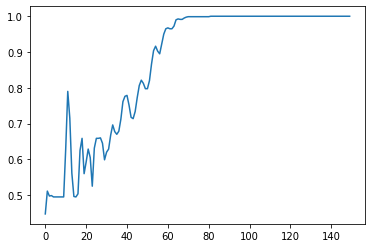

In [7]:
from matplotlib import pyplot as plt
plt.plot(acc_A)

In [8]:
import networkx as nx

def make_id(g):
    # utility function only
    # to be used in SBM dataset
    new_g = dgl.DGLGraph()
    new_g.add_nodes(g.number_of_nodes())
    new_g.ndata['feat'] = g.ndata['feat']
    nodes = np.arange(g.number_of_nodes())
    new_g.add_edges(nodes, nodes)
    new_g.edata['feat'] = torch.zeros(new_g.number_of_edges())
    return new_g


def make_erdos_renyi(g, p):

    """
    :param g: input DGL graph
    :return: erdos-renyl graph of same size
    """
    new_g = dgl.DGLGraph()
    er = nx.erdos_renyi_graph(g.number_of_nodes(), p, directed=True)
    new_g.from_networkx(er)
    new_g.ndata['feat'] = g.ndata['feat']
    new_g.edata['feat'] = torch.zeros(new_g.number_of_edges())
    return new_g

# identity

In [9]:
net = Net()
print(net)
g = make_id(g)
print(g)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
all_logits = []
all_acc = []


for epoch in range(150):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    all_logits.append(logits.detach()) # for visualization
    
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = evaluate(net, g, features, labels, test_mask)
    all_acc.append(acc)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
            epoch, loss.item(), acc))

acc_I = all_acc

Net(
  (layer1): TAGConv(
    (lin): Linear(in_features=3, out_features=16, bias=True)
  )
  (layer2): TAGConv(
    (lin): Linear(in_features=64, out_features=2, bias=True)
  )
)
DGLGraph(num_nodes=1000, num_edges=1000,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(), dtype=torch.float32)})
Epoch 00000 | Loss 1.3156 | Test Acc 0.5012
Epoch 00001 | Loss 1.0393 | Test Acc 0.5012
Epoch 00002 | Loss 0.8272 | Test Acc 0.5012
Epoch 00003 | Loss 0.7216 | Test Acc 0.4950
Epoch 00004 | Loss 0.7355 | Test Acc 0.4950
Epoch 00005 | Loss 0.7981 | Test Acc 0.4950
Epoch 00006 | Loss 0.8377 | Test Acc 0.4950
Epoch 00007 | Loss 0.8386 | Test Acc 0.4950
Epoch 00008 | Loss 0.8112 | Test Acc 0.4950
Epoch 00009 | Loss 0.7714 | Test Acc 0.4950
Epoch 00010 | Loss 0.7339 | Test Acc 0.4988
Epoch 00011 | Loss 0.7101 | Test Acc 0.5112
Epoch 00012 | Loss 0.7046 | Test Acc 0.5050
Epoch 00013 | Loss 0.7138 | Test Acc 0.5050
Epoch 00014 | Loss 

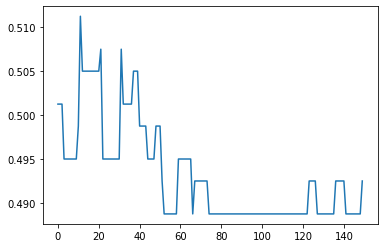

In [10]:
from matplotlib import pyplot as plt
plt.plot(acc_I)

# Erdos Renyl

Net(
  (layer1): TAGConv(
    (lin): Linear(in_features=3, out_features=16, bias=True)
  )
  (layer2): TAGConv(
    (lin): Linear(in_features=64, out_features=2, bias=True)
  )
)
DGLGraph(num_nodes=1000, num_edges=500500,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(), dtype=torch.float32)})
Epoch 00000 | Loss 0.7425 | Test Acc 0.5112
Epoch 00001 | Loss 0.7173 | Test Acc 0.5112
Epoch 00002 | Loss 0.7250 | Test Acc 0.5112
Epoch 00003 | Loss 0.7110 | Test Acc 0.4988
Epoch 00004 | Loss 0.7000 | Test Acc 0.4950
Epoch 00005 | Loss 0.7013 | Test Acc 0.4950
Epoch 00006 | Loss 0.7033 | Test Acc 0.4950
Epoch 00007 | Loss 0.6988 | Test Acc 0.4950
Epoch 00008 | Loss 0.6930 | Test Acc 0.5012
Epoch 00009 | Loss 0.6924 | Test Acc 0.5050
Epoch 00010 | Loss 0.6954 | Test Acc 0.5050
Epoch 00011 | Loss 0.6958 | Test Acc 0.5012
Epoch 00012 | Loss 0.6931 | Test Acc 0.4888
Epoch 00013 | Loss 0.6913 | Test Acc 0.4925
Epoch 00014 | Los

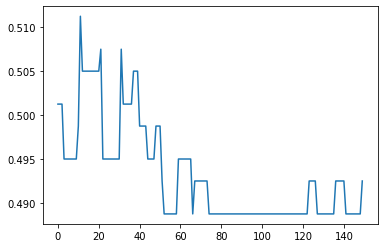

In [11]:
net = Net()
print(net)
g = make_erdos_renyi(g, 0.5)
print(g)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
all_logits = []
all_acc = []

for epoch in range(150):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    all_logits.append(logits.detach()) # for visualization
    
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = evaluate(net, g, features, labels, test_mask)
    all_acc.append(acc)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
            epoch, loss.item(), acc))

acc_ER = all_acc
plt.plot(acc_I)

# Overall Plot

In [12]:
import pandas as pd
print(len(acc_A))
print(len(acc_I))
print(len(acc_ER))
r = np.arange(len(acc_A))
# make dataframe
df1 = pd.DataFrame({'acc':acc_A,
                   'graph':'dataset',
                   'trainSamplePerLabel':r})
df2 = pd.DataFrame({'acc':acc_I,
                   'graph':'identity',
                   'trainSamplePerLabel':r})
df3 = pd.DataFrame({'acc':acc_ER,
                   'graph':'ER',
                  'trainSamplePerLabel':r})
df = pd.concat([df1,df2,df3],ignore_index=True)
print(df)

150
150
150
         acc    graph  trainSamplePerLabel
0    0.44750  dataset                    0
1    0.51125  dataset                    1
2    0.49750  dataset                    2
3    0.49875  dataset                    3
4    0.49500  dataset                    4
..       ...      ...                  ...
445  0.49000       ER                  145
446  0.49375       ER                  146
447  0.48875       ER                  147
448  0.48875       ER                  148
449  0.48875       ER                  149

[450 rows x 3 columns]


<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x7f95180a4580>>


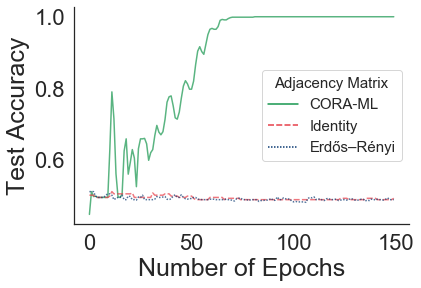

<Figure size 2880x2160 with 0 Axes>

In [13]:
import matplotlib as mpl
import seaborn as sn
%matplotlib inline

# set colors
colors = [ "#14954C","#E73D48","#083871"]
sn.set(font_scale=2)
sn.set_palette(sn.color_palette(colors))
sn.set_style("white")

# plot
a = sn.lineplot(x="trainSamplePerLabel", y="acc", hue="graph", style="graph", markers=False,alpha=0.7,data=df)
a.set_xlabel("Number of Epochs",fontsize=25)
a.set_ylabel("Test Accuracy",fontsize=25)
sn.despine()
legend = a.legend()
legend.texts[0].set_text("Adjacency Matrix")
handles, labels = a.get_legend_handles_labels()
labels[1] = "CORA-ML"
labels[2] = "Identity"
labels[3] = "Erdős–Rényi"
a.legend(handles=handles[1:], labels=labels[1:], title="Adjacency Matrix",fontsize=15,title_fontsize=15)
print(a.legend)
plt.figure(figsize=(40,30))
plt.tight_layout()
a.figure.savefig("compareGraphEffect.png",dpi=500)
